In [ ]:
!pip install -qU langgraph langchain langsmith openai langchain_openai langchain_community

In [ ]:
import os

os.environ['OPENAI_API_KEY'] = 'YOUR_OPENAI_API_KEY'

# TNT-LLM: Text Mining at Scale

TNT-LLM describes a taxonomy generation and classification system.

It generates a rich, interpretable taxonomy of user intents (or other categories) from raw conversation logs. This taxonomy can then be used downstream by LLMs to label logs, which in turn can be used as training data to adapt a cheap classifier (such as logistic regression classifier on embeddings) that can be deployed in the app.

The TNT-LLM has 3 main phases:
1. Generate taxonomy
2. Label training data
3. Finetune classifier + deploy

To generate the taxonomy, TNT-LLM propses 5 steps:
1. **Summarize** chat logs using a lower-cost LLM (batched over all logs in the sample)
2. **Batch** the logs into random minibatches
3. **Generate** an initial taxonomy from the first minibatch
4. **Update** the taxonomy on each subsequent minibatch via a critique and revise prompt
5. **Review** the final taxonomy, scoring its quality and generating a final value using a final sample

# Phase 1: Define the graph

## Graph State

Since each node of a StateGraph accepts the state (and returns an updated state), we will define that at the outset. Our flow takes in a list of documents, batches them, and then generates and refines candidate taxonomies as interpretable "clusters".

In [3]:
import logging
import operator
from typing import Annotated, List, Optional
from typing_extensions import TypedDict

In [4]:
# create a logging instance
logging.basicConfig(level=logging.WARNING)
logger = logging.getLogger('tnt-llm')

In [5]:
class Doc(TypedDict):
    id: str
    content: str
    summary: Optional[str]
    explanation: Optional[str]
    category: Optional[str]


class TaxonomyGenerationState(TypedDict):
    # The raw docs; we inject summaries within them in the first step
    documents: List[Doc]
    # Indices to be concise
    minibatches: List[List[int]]
    # Candidate Taxonomies (full trajectory)
    clusters: Annotated[List[List[dict]], operator.add]

## Define nodes

### 1.Summarize Docs

Chat logs can get quite long. The taxonomy generation step needs to see large, diverse minibatches to be able to adequately capture the distribution of categories. To ensure they can all fit efficiently into the context window, we first summarize each chat log. Downstream steps will use these summaries instead of the raw doc content.

In [6]:
import re

from langchain import hub
from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnableConfig, RunnableLambda, RunnablePassthrough

In [7]:
summary_prompt = hub.pull('wfh/tnt-llm-summary-generation').partial(
    summary_length=20,
    explanation_length=30,
)


def parse_summary(xml_string: str) -> dict:
    summary_pattern = r"<summary>(.*?)</summary>"
    explanation_pattern = r"<explanation>(.*?)</explanation>"

    summary_match = re.search(summary_pattern, xml_string, re.DOTALL)
    explanation_match = re.search(explanation_pattern, xml_string, re.DOTALL)

    summary = summary_match.group(1).strip() if summary_match else ""
    explanation = explanation_match.group(1).strip() if explanation_match else ""

    return {'summary': summary, 'explanation': explanation}


summary_llm_chain = (
    summary_prompt
    | ChatOpenAI(model='gpt-3.5-turbo')
    | StrOutputParser()
    # Customize the tracing name for easier organization
).with_config(run_name='GenerateSummary')

summary_chain = summary_llm_chain | parse_summary

/usr/local/lib/python3.10/dist-packages/langsmith/client.py:261: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


In [8]:
# Now combine as a "map" operation in a map-reduce chain
# Input: state
# Output: state U summaries
# Process docs in parallel
def get_content(state: TaxonomyGenerationState):
    docs = state['documents']
    return [{'content': doc['content']} for doc in docs]


map_step = RunnablePassthrough.assign(
    summaries=get_content
    # This effectively creates a "map" operation
    # Note we can make this more robust by handling individual errors
    | RunnableLambda(func=summary_chain.batch,
                     afunc=summary_chain.abatch)
)


def reduce_summaries(combined: dict) -> TaxonomyGenerationState:
    summaries = combined['summaries']
    documents = combined['documents']

    return {
        'documents': [
            {
                'id': doc['id'],
                'content': doc['content'],
                'summary': summ_info['summary'],
                'explanation': summ_info['explanation'],
            }
            for doc, summ_info in zip(documents, summaries)
        ]
    }


# This is the node
map_reduce_chain = map_step | reduce_summaries

### 2.Split into Minibatches

Each minibatch contains a random sample of docs. This lets the flow identify inadequacies in the current taxonomy using new data.

In [9]:
import random

def get_minibatches(state: TaxonomyGenerationState, config: RunnableConfig):
    batch_size = config['configurable'].get('batch_size', 200)
    original = state['documents']
    indices = list(range(len(original)))
    random.shuffle(indices)

    if len(indices) < batch_size:
        # Don't pad needlessly if we can't fill a single batch
        return [indices]

    num_full_batches = len(indices) // batch_size

    batches = [
        indices[i * batch_size : (i + 1) * batch_size]
        for i in range(num_full_batches)
    ]

    leftovers = len(indices) % batch_size
    if leftovers:
        last_batch = indices[num_full_batches * batch_size :]
        elements_to_add = batch_size - leftovers
        last_batch += random.sample(indices, elements_to_add)
        batches.append(last_batch)

    return {'minibatches': batches}

### 3.Taxonomy Generation Utilities

This creates a `generate -> update -> review` cycle. Each node shares a LOT of logic, which we have factored out into the shared functions below.

In [10]:
from typing import Dict

from langchain_core.runnables import Runnable


def parse_taxo(output_text: str) -> Dict:
    """Extract the taxonomy from the generated output"""
    cluster_matches = re.findall(
        r"\s*<id>(.*?)</id>\s*<name>(.*?)</name>\s*<description>(.*?)</description>\s*",
        output_text,
        re.DOTALL,
    )
    clusters = [
        {
            'id': id.strip(),
            'name': name.strip(),
            'description': description().strip(),
        }
        for id, name, description in cluster_matches
    ]

    # We don't parse the explanation since it is not used downstream
    return {'clusters': clusters}


def format_docs(docs: List[Doc]) -> str:
    xml_table = "<conversations>\n"

    for doc in docs:
        xml_table += f"<conv_summ id={doc['id']}>{doc['summary']}</conv_summ>\n"
    xml_table += "</conversations>"

    return xml_table


def format_taxonomy(clusters):
    xml = "<cluster_table>\n"
    for label in clusters:
        xml += "  <cluster>\n"
        xml += f"    <id>{label['id']}</id>\n"
        xml += f"    <name>{label['name']}</name>\n"
        xml += f"    <description>{label['description']}</description>\n"
        xml += "  </cluster>\n"
    xml += "</cluster_table>"

    return xml


def invoke_taxonomy_chain(
        chain: Runnable,
        state: TaxonomyGenerationState,
        config: RunnableConfig,
        mb_indices: List[int],
) -> TaxonomyGenerationState:
    configurable = config['configurable']
    docs = state['documents']
    minibatch = [docs[idx] for idx in mb_indices]
    data_table_xml = format_docs(minibatch)

    previous_taxonomy = state['clusters'][-1] if state['clusters'] else []
    cluster_table_xml = format_taxonomy(previous_taxonomy)

    updated_taxonomy = chain.invoke(
        {
            'data_xml': data_table_xml,
            'use_case': configurable['use_case'],
            'cluster_table_xml': cluster_table_xml,
            'suggestion_length': configurable.get('suggestion_length', 30),
            'cluster_name_length': configurable.get('cluster_name_length', 10),
            'cluster_description_length': configurable.get('cluster_description_length', 30),
            'explanation_length': configurable.get('explanation_length', 20),
            'max_num_clusters': configurable.get('max_num_clusters', 25),
        }
    )

    return {'clusters': [updated_taxonomy['clusters']]}

### 4.Generate initial taxonomy

In [12]:
# We will share an LLM for each step of the generate -> update -> review cycle
taxonomy_generation_llm = ChatOpenAI(model='gpt-3.5-turbo')

# Initial generation
taxonomy_generation_prompt = hub.pull('wfh/tnt-llm-taxonomy-generation').partial(
    use_case='Generate the taxonomy that can be used to label the user intent in the conversation.',
)

taxonomy_gen_llm_chain = (
    taxonomy_generation_prompt
    | taxonomy_generation_llm
    | StrOutputParser()
).with_config(run_name='GenerateTaxonomy')


generate_taxonomy_chain = taxonomy_gen_llm_chain | parse_taxo


def generate_taxonomy(state: TaxonomyGenerationState, config: RunnableConfig) -> TaxonomyGenerationState:
    return invoke_taxonomy_chain(
        generate_taxonomy_chain,
        state,
        config,
        state['minibatches'][0]
    )

/usr/local/lib/python3.10/dist-packages/langsmith/client.py:261: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


### 5.Update Taxonomy

This is a "critique -> revise" step that is repeated N times

In [13]:
from shutil import which
taxonomy_update_prompt = hub.pull('wfh/tnt-llm-taxonomy-update')

taxo_update_llm_chain = (
    taxonomy_update_prompt
    | taxonomy_generation_llm
    | StrOutputParser()
).with_config(run_name='UpdateTaxonomy')

update_taxonomy_chain = taxo_update_llm_chain | parse_taxo


def update_taxonomy(state: TaxonomyGenerationState, config: RunnableConfig) -> TaxonomyGenerationState:
    which_mb = len(state['clusters']) % len(state['minibatches'])

    return invoke_taxonomy_chain(
        update_taxonomy_chain,
        state,
        config,
        state['minibatches'][which_mb]
    )

/usr/local/lib/python3.10/dist-packages/langsmith/client.py:261: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


### 6.Review Taxonomy

This runs once we have processed all the minibatches

In [14]:
taxonomy_review_prompt = hub.pull('wfh/tnt-llm-taxonomy-review')

taxo_review_llm_chain = (
    taxonomy_review_prompt
    | taxonomy_generation_llm
    | StrOutputParser()
).with_config(run_name='ReviewTaxonomy')

review_taxonomy_chain = taxo_review_llm_chain | parse_taxo


def review_taxonomy(state: TaxonomyGenerationState, config: RunnableConfig) -> TaxonomyGenerationState:
    batch_size = config['configurable'].get('batch_size', 200)
    original = state['documents']
    indices = list(range(len(original)))
    random.shuffle(indices)

    return invoke_taxonomy_chain(
        review_taxonomy_chain,
        state,
        config,
        indices[:batch_size]
    )

/usr/local/lib/python3.10/dist-packages/langsmith/client.py:261: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


## Compile the Graph

In [15]:
from langgraph.graph import StateGraph, START, END

def should_review(state: TaxonomyGenerationState) -> str:
    num_minibatches = len(state['minibatches'])
    num_revisions = len(state['clusters'])
    if num_revisions < num_minibatches:
        return "update_taxonomy"
    return "review_taxonomy"



graph = StateGraph(TaxonomyGenerationState)
# Add nodes
graph.add_node('summarize', map_reduce_chain)
graph.add_node('get_minibatches', get_minibatches)
graph.add_node('generate_taxonomy', generate_taxonomy)
graph.add_node('update_taxonomy', update_taxonomy)
graph.add_node('review_taxonomy', review_taxonomy)
# Add edges
graph.add_edge(START, 'summarize')
graph.add_edge('summarize', 'get_minibatches')
graph.add_edge('get_minibatches', 'generate_taxonomy')
graph.add_edge('generate_taxonomy', 'update_taxonomy')
graph.add_conditional_edges(
    'update_taxonomy',
    should_review,
    {
        'update_taxonomy': 'update_taxonomy',
        'review_taxonomy': 'review_taxonomy',
    }
)
graph.add_edge('review_taxonomy', END)

app = graph.compile()

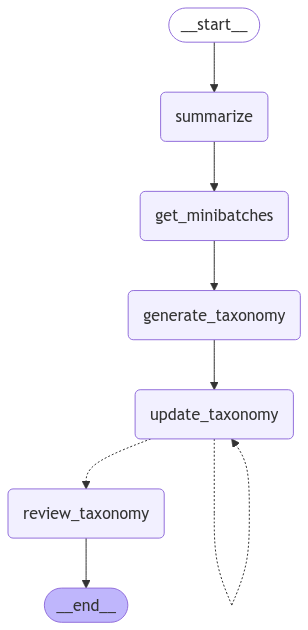

In [16]:
from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))

# Use the Graph

The docs can contain any content, but we have found it works really well on chatbot logs.

We can customize the `run_to_doc` function below:

In [ ]:
from datetime import datetime, timedelta

from langsmith import Client

project_name = "OUR PROJECT NAME"
client = Client()

past_week = datetime.now() - timedelta(days=7)
runs = list(
    client.list_runs(
        project_name=project_name,
        filter="eq(is_root, true)",
        start_time=past_week,
        # We only need to return the inputs + outputs
        select=['inputs', 'outputs'],
    )
)


# Convert the langsmith traces to our graph's Doc object
def run_to_doc(run) -> Doc:
    turns = []
    idx = 0
    for turn in run.inputs.get('chat_history') or []:
        key, value = next(iter(turn.items()))
        turns.append(f"<{key} idx={idx}>\n{value}\n</{key}>")
        idx += 1
    turns.append(
        f"<human idx={idx}>\n{run.inputs['question']}\n</human>"
    )

    if run.outputs and run.outputs['output']:
        turns.append(
            f"<ai idx={idx+1}>\n{run.outputs['output']}\n</ai>"
        )

    return {'id': str(run.id), 'content': ('\n'.join(turns))}

## Invoke

Now we can convert the runs to docs and kick off our graph flow. This will take some time. The summary step takes the longest.

In [ ]:
from langchain_community.cache import InMemoryCache
from langchain.globals import set_llm_cache

set_llm_cache(InMemoryCache())

In [ ]:
docs = [run_to_doc(run) for run in runs if run.inputs]
docs = random.sample(docs, min(len(docs), 1000))
use_case = (
    "Generate the taxonomy that can be used both to label the user intent"
    " as well as the identify any required documentation (references, how-tos, etc.)"
    " that would be benefit the user."
)

stream = app.stream(
    {'document': docs},
    {
        'configurable': {
            'use_case': use_case,
            # optional:
            'batch_size': 400,
            'suggestion_length': 30,
            'cluster_name_length': 10,
            'cluster_description_length': 30,
            'explanation_length': 20,
            'max_num_clusters': 25,
        },
        # we batch and summarize the docs.
        # To avoid getting errors, we will limit the degree of parallelism to permit
        'max_concurrency': 2,
    }
)

for step in stream:
    node, state = next(iter(step.items()))
    print(node, str(state)[:20] + '...')

# Final Result

In [ ]:
from IPython.display import Markdown

def format_taxonomy_md(clusters):
    md = "## Final Taxonomy\n\n"
    md += "| ID | Name | Description |\n"
    md += "|----|------|-------------|\n"

    # Fill the table with cluster data
    for label in clusters:
        id = label['id']
        name = label['name'].replace("|", "\\|") # escape any pipe characters within the content
        description = label['description'].replace("|", "\\|")

        md += f"| {id} | {name} | {description} |\n"

    return md

Markdown(format_taxonomy_md(step["__end__"]['clusters'][-1]))

# Phase 2: Labeling

Now that we have our taxonomy, it's time to label a subset of our data to train a classifier.

Input classification can be useful for anything from in-line prompt optimization (tailor the prompt for each classified intent), to system improvements (identifying categories for which the system does not produce good responses) to product analytics (understand which intent categoies could be improved to drive profits).

The problem is that LLM-based tagging can be expensive.

Embeddings can be ~100 times cheaper to compute, and a simple logistic regression classifier on top of that would add negligible cost.

## Label Training Data

Use an LLM to label the data in a fully-automated fashion. For better accuracy, we can sample a portion of the results to label by hand as well to verify the quality.

In [28]:
labeling_prompt = hub.pull('wfh/tnt-llm-classify')
labeling_prompt.messages

/usr/local/lib/python3.10/dist-packages/langsmith/client.py:261: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


[SystemMessagePromptTemplate(prompt=PromptTemplate(input_variables=['taxonomy'], input_types={}, partial_variables={}, template="\nYour task is to use the provided taxonomy to categorize the overall topic or intent of a conversation between a human and an AI assistant.  \n\nFirst, here is the taxonomy to use:\n\n<taxonomy>\n{taxonomy}\n</taxonomy>\n\nTo complete the task:\n\n1. Carefully read through the entire conversation, paying attention to the key topics discussed and the apparent intents behind the human's messages.\n2. Consult the taxonomy and identify the single most relevant category that best captures the overall topic or intent of the conversation. \n3. Write out a chain of reasoning for why you selected that category. Explain how the category fits the content of the conversation, referencing specific statements or passages as evidence. Output this reasoning inside <reasoning></reasoning> tags.\n\n4. Output the name of the category you chose inside <category></category> tags

In [ ]:
labeling_llm = ChatOpenAI(model='gpt-4o-mini')

labeling_llm_chain = (
    labeling_prompt
    | labeling_llm
    | StrOutputParser()
).with_config(run_name='ClassifyDocs')


def parse_labels(output_text: str) -> Dict:
    """Parse the generated labels from the predictions"""
    category_matches = re.findall(
        r"\s*<category>(.*?)</category>.*",
        output_text,
        re.DOTALL,
    )
    categories = [
        {'category': category.strip()}
        for category in category_matches
    ]

    if len(categories) > 1:
        logger.warning(f"Multiple selected categories: {categories}")

    label = categories[0]
    stripped = re.sub(r"^\d+\.\s*", "", label["category"]).strip()

    return {'category': stripped}


labeling_chain = labeling_llm_chain | parse_labels

In [ ]:
final_taxonomy = step["__end__"]['cluster'][-1]
xml_taxonomy = format_taxonomy(final_taxonomy)

results = labeling_chain.batch(
    [
        {
            'content': doc['content'],
            'taxonomy': xml_taxonomy,
        }
        for doc in docs
    ],
    {'max_concurrency': 5},
    return_exceptions=True,
)

# Update the docs to include the categories
updated_docs = [
    {**doc, **category}
    for doc, category in zip(docs, results)
]

In [ ]:
from langchain_openai import OpenAIEmbeddings

encoder = OpenAIEmbeddings(model='text-embedding-3-large')
vectors = encoder.embed_documents([doc['content'] for doc in docs])
embedded_docs = [
    {**doc, 'embedding': v}
    for doc, v in zip(updated_docs, vectors)
]

## Train Classifier

Now that we have extracted the features from the text, we can generate the classifier on them.

In [ ]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight


# Create a dictionary mapping category names to their indices in the taxonomy
category_to_index = {
    d['name']: i
    for i, d in enumerate(final_taxonomy)
}
category_to_index['Other'] = len(category_to_index)

# Convert category strings to numeric labels
labels = [
    category_to_index.get(d['category'], category_to_index['Other'])
    for d in embedded_docs
]
label_vectors = [d['embedding'] for d in embedded_docs]

X_train, X_test, y_train, y_test = train_test_split(
    label_vectors,
    labels,
    test_size=0.2,
    random_state=101,
)

# Calculate class weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train,
)
class_weight_dict = dict(enumerate(class_weights))

# Weight the classes to partially handle imbalanced data
model = LogisticRegression(class_weight=class_weight_dict)
model.fit(X_train, y_train)

train_preds = model.predict(X_train)
test_preds = model.predict(X_test)

train_acc = accuracy_score(y_train, train_preds)
test_acc = accuracy_score(y_test, test_preds)
train_f1 = f1_score(y_train, train_preds, average='weighted')
test_f1 = f1_score(y_test, test_preds, average='weighted')

print(f"Train Accuracy: {train_acc}")
print(f"Test Accuracy: {test_acc}")
print(f"Train F1 Score: {train_f1}")
print(f"Test F1 Score: {test_f1}")

# Phase 3: Deploy

Now that we have our classifier, we can easily deploy it and apply to future runs. All we need is to embed the input and apply our `LogisticRegression` classifier.

We will use `joblib` library to serialize our classifier.

In [ ]:
from joblib import dump as jl_dump

categories = list(category_to_index)

# Save the model and categories to a file
with open('model.joblib', 'wb') as file:
    jl_dump((model, categories), file)

## To deploy

When deploying, we can load the classifier and intialize our embedding encoder. They can be fit together easily using LCEL:

In [ ]:
from joblib import load as jl_load
from langchain_openai import OpenAIEmbeddings

loaded_model, loaded_categories = jl_load('model.joblib')
encoder = OpenAIEmbeddings(model='text-embedding-3-large')


def get_category_name(predictions):
    return [loaded_categories[pred] for pred in predictions]


classifier = (
    RunnableLambda(encoder.embed_documents, encoder.aembed_documents)
    | loaded_model.predict
    | get_category_name
)

In [ ]:
client = Client()

past_5_min = datetime.now() - timedelta(minutes=5)
runs = list(
    client.list_runs(
        project_name=project_name,
        filter="eq(is_root, true)",
        start_time=past_5_min,
        # We only need to return the inputs + outputs
        select=["inputs", "outputs"],
        limit=100,
    )
)
docs = [run_to_doc(r) for r in runs]

In [ ]:
classes = classifier.invoke([doc["content"] for doc in docs])
print(classes[:2])